## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [2]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    
    # turning b to a numpy array for easier index manipulation:
    b = np.array(b)
    
    # defining some utility functions for the calculations. Performance-wise it'd have been better to define them outside the loop
    sigz = lambda x : 1 - 2*x # action of sigma_z on a single bit
    h = lambda x, y : sigz(x)*sigz(y) # one term of the hamiltonian.
    
    # we get the index pairs representing the edges from `edges`, use them to index b (which gives a length 2 array), destructure that into inputs for h, and then sum that all together.
    val = np.sum([h(*b[indices]) for indices in np.array(edges)]) 
    
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1 0 0 1 1]


#### visualization of the graph

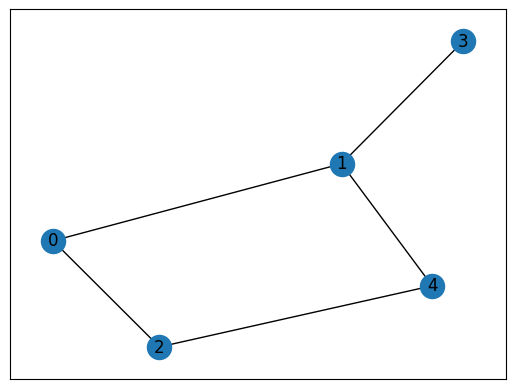

In [3]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [4]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [5]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

$$e^{-i\beta H_C} = e^{-i \beta \sum_{(i, j) \in E} \sigma_Z^i \sigma_Z^j} = \prod_{(i, j) \in E} e^{-i \beta  \sigma_Z^i \sigma_Z^j} = \prod_{(i, j) \in E } U_{ZZ}^{(i, j)}\left(2\beta \right) $$

In [6]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    edges = np.array(edges) # just for easier manipulation of indices
    
    # First we apply Rx(theta) to each qubit
    for i in range(n_qubits):
        layer.apply(RX(theta), i)
    
    # Then we apply U_ZZ on all edges :
    for edge_indices in edges:
        ind_1, ind_2 = edge_indices
        layer.apply(U_ZZ(2*beta), int(ind_1), int(ind_2))
        
    
    return layer

### Question 4

In [7]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    
    # de-interleaving parameters to make indexing clearer
    parameters = np.array(parameters)
    thetas = parameters[::2]  # every even-indexed parameter is a theta
    betas = parameters[1::2]  # every  odd-indexed parameter is a beta
    
    # Applying hadamard on every qubit
    for i in range(n_qubits):
        prog.apply(H, qubits[i])
    
    # Applying QAOA layers
    for p in range(n_layers):
        prog.apply(one_qaoa_layer(n_qubits, edges, thetas[p], betas[p]), qubits)

        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        
        #using the exact same method as Q2 (this is an adapted copy-paste of that answer)
        
        # turning b to a numpy array for easier index manipulation: (this is a bit aggressive of a method, but oh well)
        b = sample.state.bitstring
        b = np.array([int(i) for i in b])
        
        # defining some utility functions for the calculations. Performance-wise it'd have been better to define them outside the loop
        sigz = lambda x : 1 - 2*x # action of sigma_z on a single bit
        h = lambda x, y : sigz(x)*sigz(y) # one term of the hamiltonian.

        # we get the index pairs representing the edges from `edges`, use them to index b (which gives a length 2 array), destructure that into inputs for h, and then sum that all together.
        obs += np.sum([h(*b[indices])*sample.probability for indices in np.array(edges)]) # this time we multiply the output of h by `sample.probability` cause we are doing a statistical average of the observable
    # END TODO
    return obs
    
        

In [8]:
import numpy as np
np.random.random(3)

array([0.82917861, 0.31747155, 0.39817596])

In [9]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

It looks like we need 9 to 10 layers to reach the optimum value.

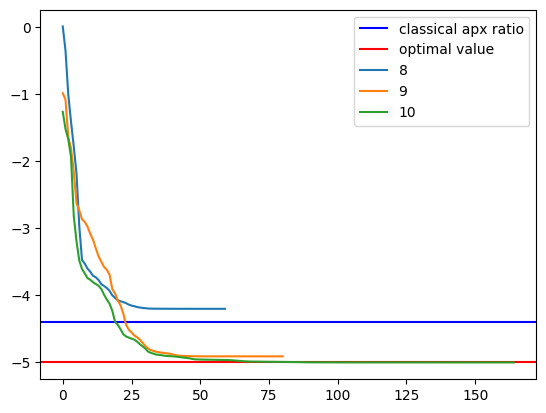

In [31]:
import matplotlib.pylab as plt

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')

for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        #print("iter") # NOTE : commented this out cause it made the output scroll a lot. Hope it's alright
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end='\r') # NOTE : changed the terminator for results to stay on the same line when they update

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum

plt.legend()

### Question 6: smart initialization

Developping $\int_0^T H(s)\mathrm{d}s$, expanding the expression of $H$ and then using the property of the operator exponential we assumed, 

$$\left| \psi_f \right\rangle = \prod_{k = 1}^{p} \underbrace{e^{-i\frac{T}{p}\left(1 - \frac{k}{p} \right)\sum_k \sigma_x^k}}_{ = R_X\left(2\frac{T}{p}\left(1 - \frac{k}{p} \right) \right)\\ \text{on all qubits}} 
\underbrace{e^{-i\frac{T}{p}\frac{k}{p}H_C}}_{ = U_{ZZ}\left(2\frac{Tk}{p^2}\right)\\ \text{on all qubits pairs linked by an edge}}\left| \psi_0 \right\rangle$$

This is essentially the way out QAOA algo works : applying $RX$ then $U_{ZZ}$ repeatedly. We can thus directly identify $\theta_k$ and $\beta_k$.

So in the end we get : $$\boxed{\begin{cases} \theta_k =2\frac{T}{p}\left(1 - \frac{k}{p}\right)\\ \beta_k = \frac{Tk}{p^2}\end{cases}}$$

For us, $p$ is the number of layers minus 1.

**It looks like this conditioning of the parameters gives much faster convergence (~ 20 steps max) for a lower number of layers but the minimum value isn't reached quite as well.** I'd suppose that this is due to the approximation $e^{A + B} = e^A e^B$ not being that good and accumulating errors which throw the optimization off.

The next 3 figures are for $T = 1$, $T = 10$ and $T = 0.1$. It looks like too low T makes the algorithm converge towards wrong values, and too high T makes it converge slower and need more layers.

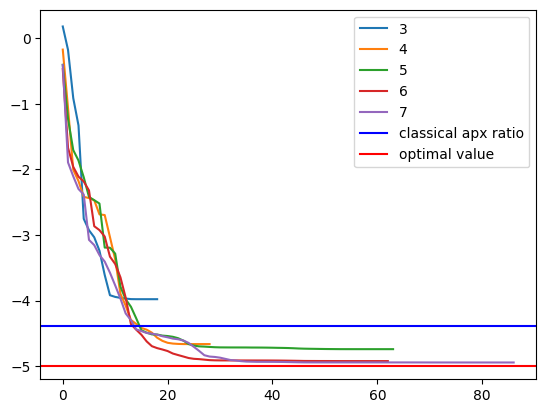

In [16]:
import matplotlib.pylab as plt

T = 1.

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end='\r')

    # TODO implement parameter init
    parameters_init = np.zeros(num_params) #initializing parameters array
    
    # we generate the thetas and betas separately and will interleave them into parameters_init using slicing
    thetas = [2*T/nlayers*(1 - i/nlayers) for i in range(nlayers)]
    betas = [T*j/(nlayers**2)for j in range(nlayers)]
    
    # doing the interleaving
    parameters_init[::2] = thetas
    parameters_init[1::2] = betas
    

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers)) # added this line cause I think you forgot to plot backtrace
    
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

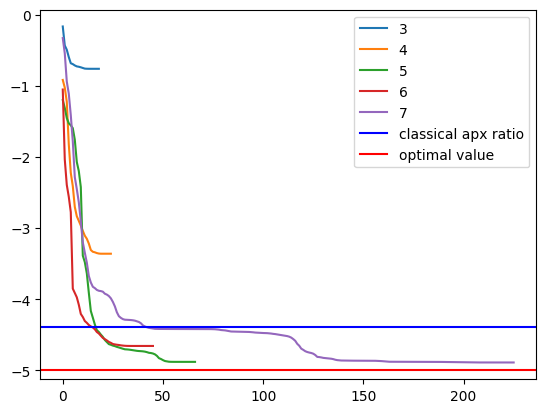

In [17]:
import matplotlib.pylab as plt

T = 10.

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end='\r')

    # TODO implement parameter init
    parameters_init = np.zeros(num_params) #initializing parameters array
    
    # we generate the thetas and betas separately and will interleave them into parameters_init using slicing
    thetas = [2*T/nlayers*(1 - i/nlayers) for i in range(nlayers)]
    betas = [T*j/(nlayers**2)for j in range(nlayers)]
    
    # doing the interleaving
    parameters_init[::2] = thetas
    parameters_init[1::2] = betas
    

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers)) # added this line cause I think you forgot to plot backtrace
    
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

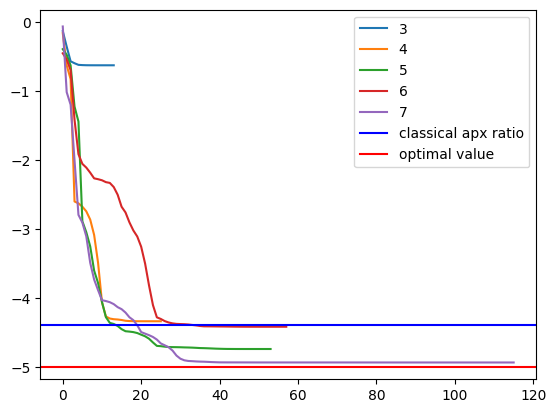

In [18]:
import matplotlib.pylab as plt

T = .1

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end='\r')

    # TODO implement parameter init
    parameters_init = np.zeros(num_params) #initializing parameters array
    
    # we generate the thetas and betas separately and will interleave them into parameters_init using slicing
    thetas = [2*T/nlayers*(1 - i/nlayers) for i in range(nlayers)]
    betas = [T*j/(nlayers**2)for j in range(nlayers)]
    
    # doing the interleaving
    parameters_init[::2] = thetas
    parameters_init[1::2] = betas
    

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers)) # added this line cause I think you forgot to plot backtrace
    
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()